# Processing individual modalities and multimodal integration of 3k brain cells

This notebooks demonstrates how individual modalities are processed and integrated to prepare the ground for downstream analysis.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

## Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [3]:
import muon as mu

In [4]:
mu.set_options(display_style = "html", display_html_expand = 0b000)

Download the data that we will use for this series of notebooks. 

It can be conveniently obtained with the [`mudatasets` library](https://github.com/gtca/mudatasets) so that multiple files are downloaded and loaded in a `MuData` object:

In [5]:
import mudatasets
mdata = mudatasets.load("brain3k_multiome", full=True)
mdata.var_names_make_unique()

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at ~/mudatasets/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at ~/mudatasets/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at ~/mudatasets/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at ~/mudatasets/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at ~/mudatasets/brain3k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature_bc_matrix.h5...


/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from ~/mudatasets/brain3k_multiome/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:396: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from ~/mudatasets/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: ~/mudatasets/brain3k_multiome/atac_fragments.tsv.gz


> More details about using `mudatasets` and available datasets can be found [in its repository](https://github.com/gtca/mudatasets).

For the record, [the original data is available here](https://www.10xgenomics.com/resources/datasets/frozen-human-healthy-brain-tissue-3-k-1-standard-2-0-0), and we will use the following files:

1. Filtered feature barcode matrix (HDF5)
1. ATAC peak annotations based on proximal genes (TSV)
1. ATAC Per fragment information file (TSV.GZ)
1. ATAC Per fragment information index (TSV.GZ index)

In [6]:
mdata

MuData object with n_obs × n_vars = 3233 × 170631
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	3233 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	3233 x 134030
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## Processing RNA

Here, we'll perform some QC and processing steps including normalisation.

In [7]:
# `rna` will point to `mdata['rna']`
# unless we copy it
rna = mdata['rna']

### QC

In [8]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: 

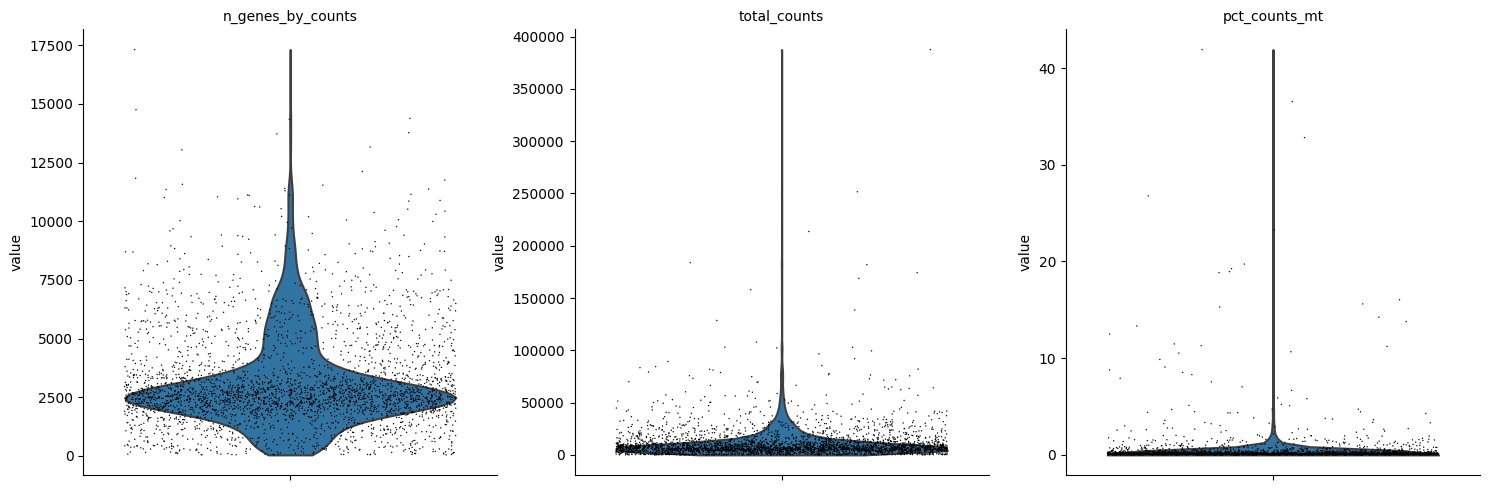

In [9]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
print(f"Before: {rna.n_obs} cells")
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
print(f"(After n_genes: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
print(f"(After total_counts: {rna.n_obs} cells)")
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 2)
print(f"After: {rna.n_obs} cells")

Before: 3233 cells
(After n_genes: 3084 cells)
(After total_counts: 3065 cells)
After: 3020 cells


Let's see how the data looks after filtering:

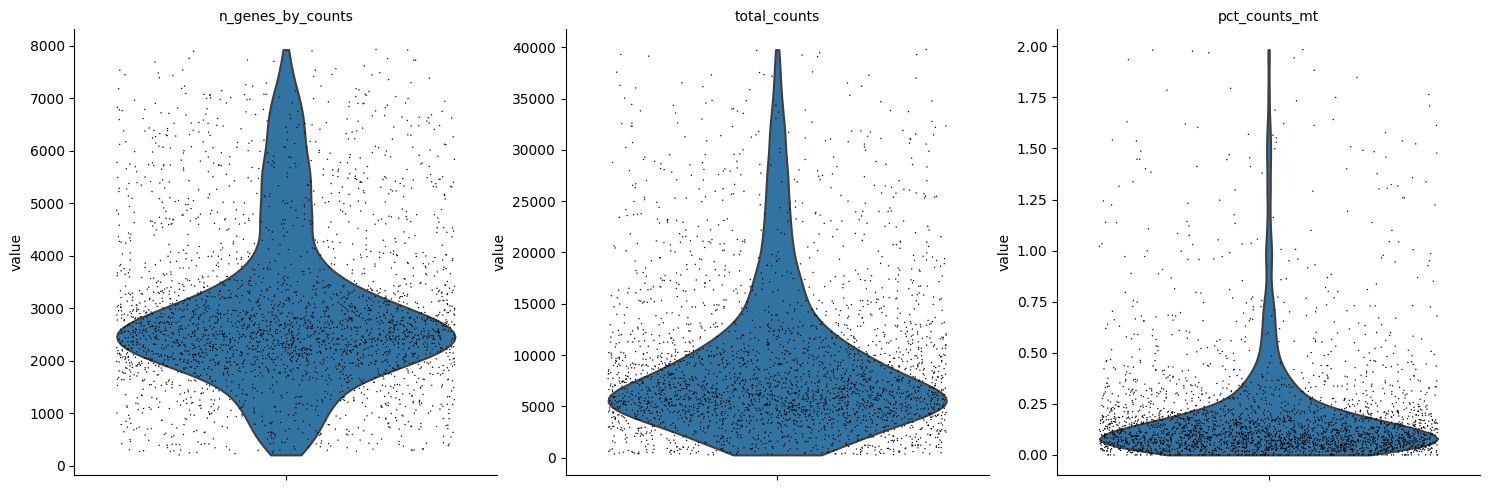

In [11]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Normalisation

In [12]:
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
# rna.raw = rna
rna.layers["lognorm"] = rna.X.copy()

### Define informative features

In [13]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

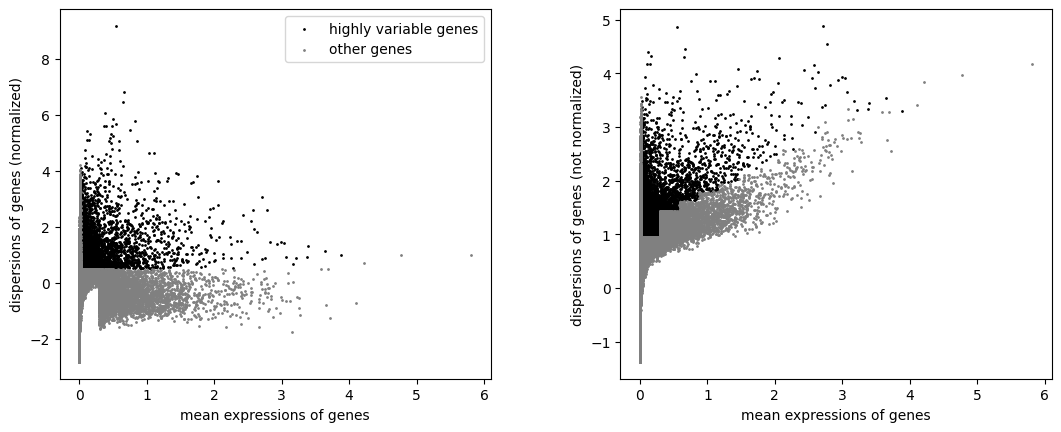

In [14]:
sc.pl.highly_variable_genes(rna)

In [15]:
np.sum(rna.var.highly_variable)

5924

### Scaling and PCA

In [16]:
sc.pp.scale(rna, max_value=10)

In [17]:
sc.tl.pca(rna, svd_solver='arpack')

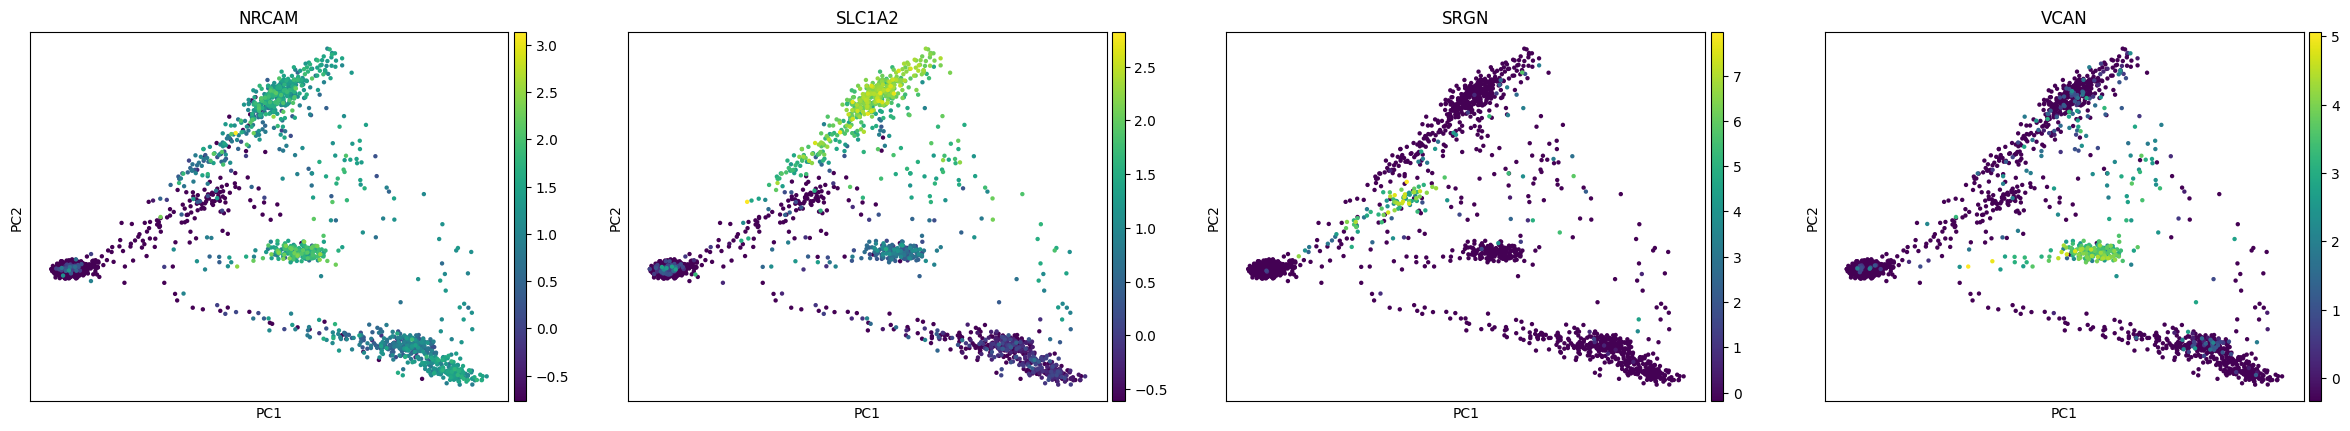

In [18]:
sc.pl.pca(rna, color=['NRCAM', 'SLC1A2', 'SRGN', 'VCAN'])

> You can see expression of some of these genes and their type and region specificity in the Protein Atlas, e.g. [SLC1A2 in astrocytes](https://www.proteinatlas.org/ENSG00000110436-SLC1A2), [SRGN in microglia](https://www.proteinatlas.org/ENSG00000122862-SRGN/single+cell+type/brain) and [VCAN in oligodendrocyte precursor cells](https://www.proteinatlas.org/ENSG00000187398-LUZP2/single+cell+type).

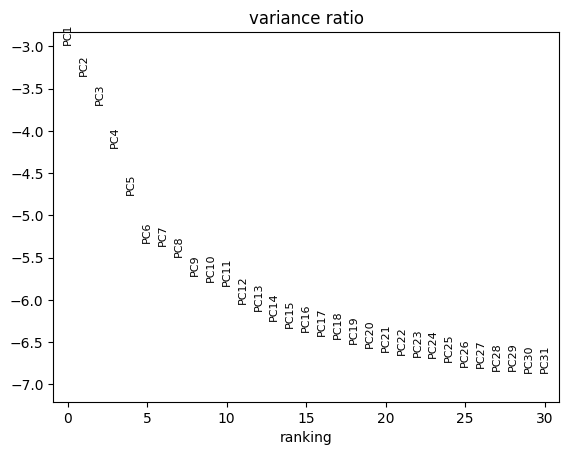

In [19]:
sc.pl.pca_variance_ratio(rna, log=True)

### Finding cell neighbours and clustering cells

In [20]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

In [21]:
sc.tl.leiden(rna, resolution=.5)

### Non-linear dimensionality reduction

In [22]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

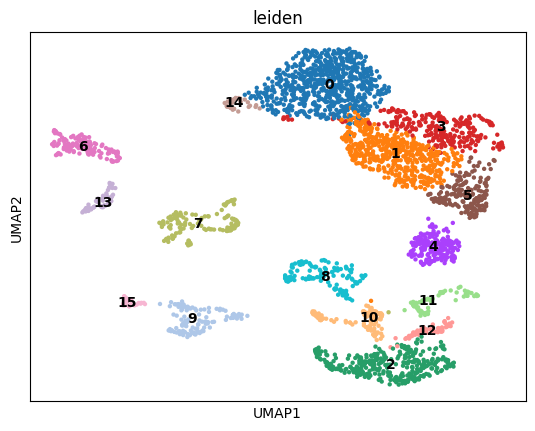

In [23]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

### Marker genes and celltypes

In [24]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.

In [25]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n            0_p       1_n            1_p      2_n            2_p  \
0    PLP1   0.000000e+00    CTNNA3   0.000000e+00   SLC1A2   0.000000e+00   
1     CNP   0.000000e+00      ST18  1.992302e-290     GPC5   0.000000e+00   
2   CRYAB   0.000000e+00   PIP4K2A  1.775347e-282   ADGRV1   0.000000e+00   
3  DBNDD2  1.140926e-286   SLC44A1  2.344859e-284    GPM6A   0.000000e+00   
4   PTGDS   0.000000e+00  IL1RAPL1  1.201356e-292     RYR3  6.273018e-302   
5   APLP1  1.209001e-294    DOCK10  1.944916e-276  PITPNC1   0.000000e+00   
6     MBP   0.000000e+00    RNF220  1.347821e-259   CTNNA2   0.000000e+00   
7    FTH1  2.670045e-306      SIK3  1.819625e-253    LSAMP   0.000000e+00   
8  RNASE1  4.994825e-237     ELMO1  4.212537e-267     SOX5   0.000000e+00   
9    QDPR  1.806916e-286   SLC24A2  4.128419e-255    NRXN1   0.000000e+00   

        3_n            3_p     4_n            4_p       5_n           5_p  \
0    CTNNA3   0.000000e+00  PCDH15  2.652644e-260    MALAT1  7.906135e-50   
1      ST18  6.978186e-266   DSCAM  2.336696e-305    CTNNA3  1.591178e-39   
2      DPYD  7.124458e-183   OPCML   0.000000e+00  HSP90AA1  4.793518e-36   
3    RNF220  1.548406e-180  PTPRZ1  2.238103e-246       DST  6.047507e-33   
4   SLC44A1  1.418382e-219  LHFPL3  2.683399e-174   SLC24A2  3.026886e-23   
5       MBP  5.637242e-199     TNR  2.855693e-170   CCDC88A  1.073638e-19   
6  IL1RAPL1  3.051642e-209   LUZP2  1.352114e-163    RNF220  5.682518e-20   
7   PIP4K2A  7.201469e-174  KCNIP4   0.000000e+00  IL1RAPL1  6.968710e-21   
8   TMEM165  7.257380e-161  LRRC4C  2.475997e-240      ST18  8.850388e-16   
9    DOCK10  2.027642e-165   CSMD1  9.004584e-279    POLR2F  2.904285e-15   

       6_n            6_p     7_n            7_p      8_n           8_p  \
0   KCNIP4   0.000000e+00  DLGAP1  8.963566e-194    LRMDA  6.608572e-69   
1   RBFOX1   0.000000e+00  RBFOX1  2.306675e-165     CD83  4.238996e-53   
2   HS6ST3  1.256068e-204  SNHG14  1.267656e-150  ST6GAL1  6.552671e-52   
3    CSMD1   0.000000e+00    SYT1  8.597039e-104   SRGAP2  8.299153e-52   
4     MEG3  4.656631e-203    PCLO   7.207201e-97   SFMBT2  4.823747e-52   
5   LRRTM4  4.263504e-303  ATRNL1  6.402239e-104    MEF2C  2.862382e-52   
6    CHRM3  9.130756e-163    NRG3  6.918291e-163   PLXDC2  1.746137e-53   
7  PHACTR1  1.999672e-227   RIMS2   1.884141e-98   CHST11  5.488205e-50   
8    KALRN  2.925946e-186   GRIP1   2.286657e-86    ITPR2  1.985314e-51   
9     SYT1  4.039716e-199    KAZN  8.369727e-100   FRMD4A  4.761944e-51   

       9_n            9_p       10_n           10_p     11_n          11_p  \
0   SNHG14  1.318458e-152       GPC5  4.747626e-143  PITPNC1  9.111519e-22   
1    MYT1L  4.228744e-112      GPM6A  6.184337e-127   SORBS1  2.769325e-21   
2   ADARB2  2.600669e-107     SLC1A2   4.501662e-99   ATP1B3  1.189084e-20   
3     KAZN  1.972062e-117     CTNNA2  1.565429e-127     MSI2  2.379704e-20   
4   CCSER1   2.340052e-97       SOX5  5.678717e-104   MALAT1  6.752891e-19   
5    FGF14  5.598255e-104     ADGRV1   8.510522e-89   ZNF331  5.170967e-18   
6    CHRM3   2.419674e-85       DTNA  6.489832e-107    NR4A3  3.365677e-15   
7     MEG3   5.315741e-91     NKAIN3   4.128601e-84    ESYT2  6.388757e-15   
8  GALNTL6   3.329208e-80      NRXN1  7.657986e-115    NR4A2  1.847265e-14   
9   FRMD4A   1.877699e-95  LINC00299   2.855548e-75     TLE1  1.991057e-14   

     12_n          12_p     13_n          13_p    14_n          14_p    15_n  \
0    GPC5  7.653579e-83     SYT1  2.014135e-63    PLP1  1.274503e-33   GRIP1   
1  ADGRV1  1.086910e-69    RIMS2  1.193609e-67    ST18  2.647254e-33    KAZN   
2  CTNNA2  6.599894e-87    RALYL  5.803705e-50    DPYD  1.470305e-28  CCSER1   
3  SLC1A2  2.793749e-65    CSMD1  4.780335e-68     MBP  2.456123e-28  RBFOX1   
4    NRG3  3.185427e-82    KALRN  3.398583e-57  CTNNA3  3.127268e-29    RGS7   
5   GPM6A  3.110578e-63  FAM155A  5.268105e-71   CRYAB  1.195638e-21  ATP8A2   
6   NRXN1  4.834023e-77     NRG3  1.653593e-76   ENPP2  3.207358e

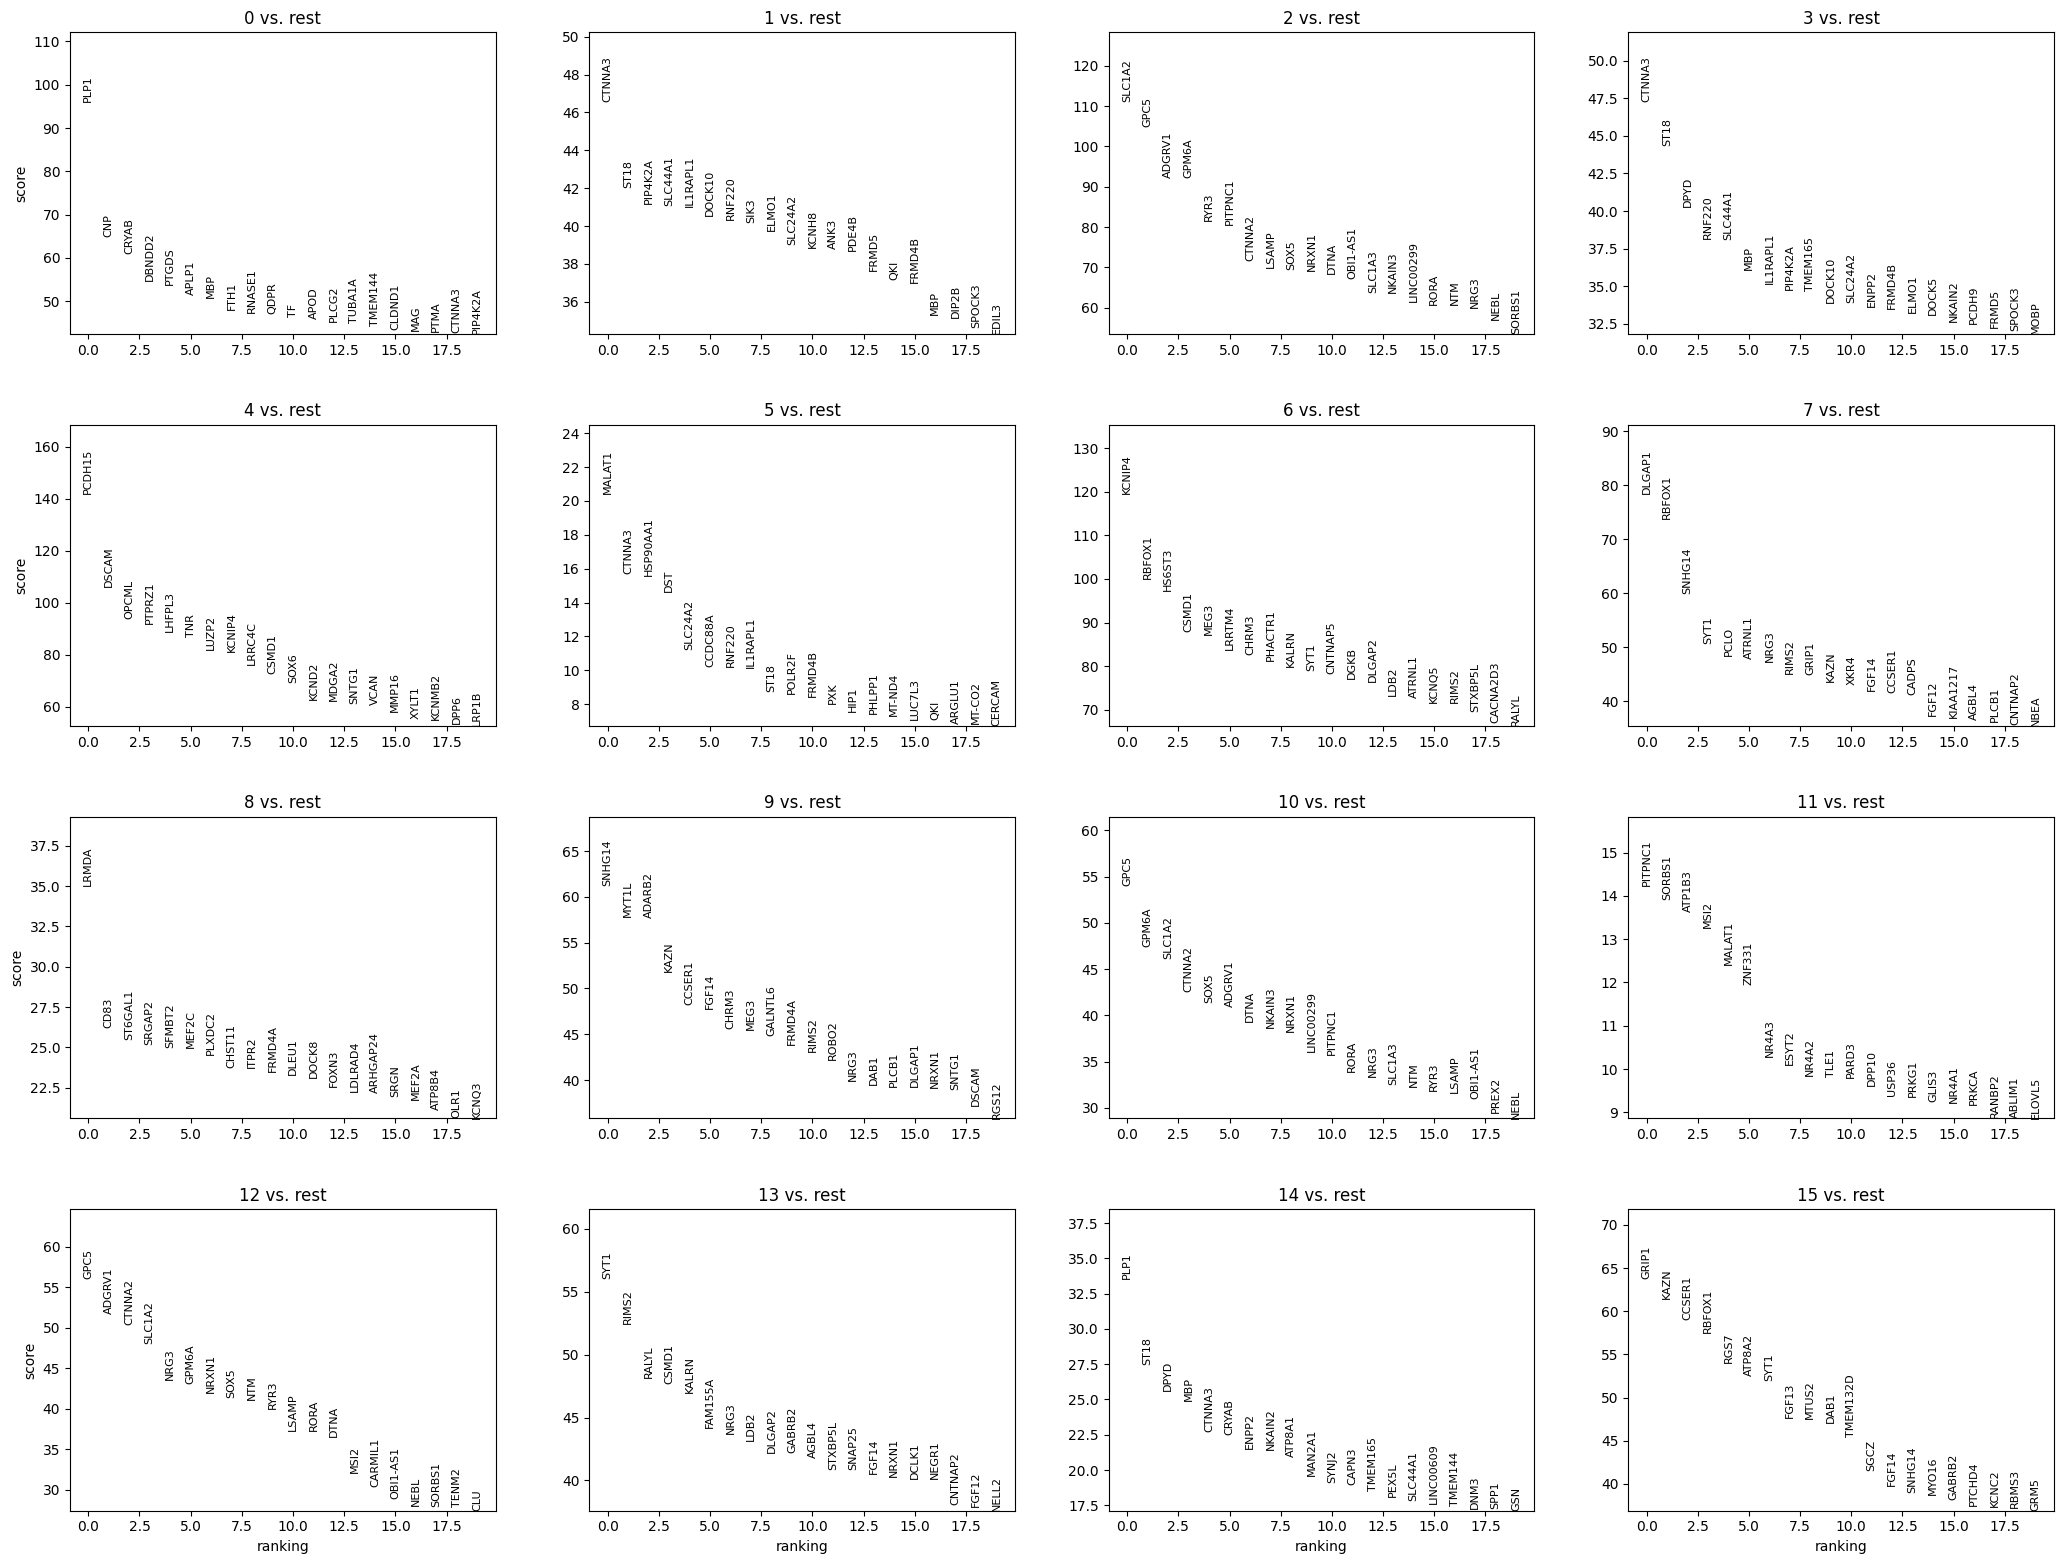

In [26]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

### Cell type annotation

There are multiple complementary approaches to assign biologically meaningful cluster labels.

#### Marker genes

A straightforward approach is to look at each cluster's marker genes. For instance, Proteolipid protein 1 (`PLP1`) together with 2′,3′-Cyclic nucleotide phosphodiesterase (`CNP`) indicate that the **cluster 0** is likely to consist of **oligodendrocytes**. With `CTNNA3`, which is [characeristic for oligodendrocytes](https://www.proteinatlas.org/ENSG00000183230-CTNNA3/single+cell+type), we can assign this label to other clusters as well (`1`, `3`, `5`, `14`).

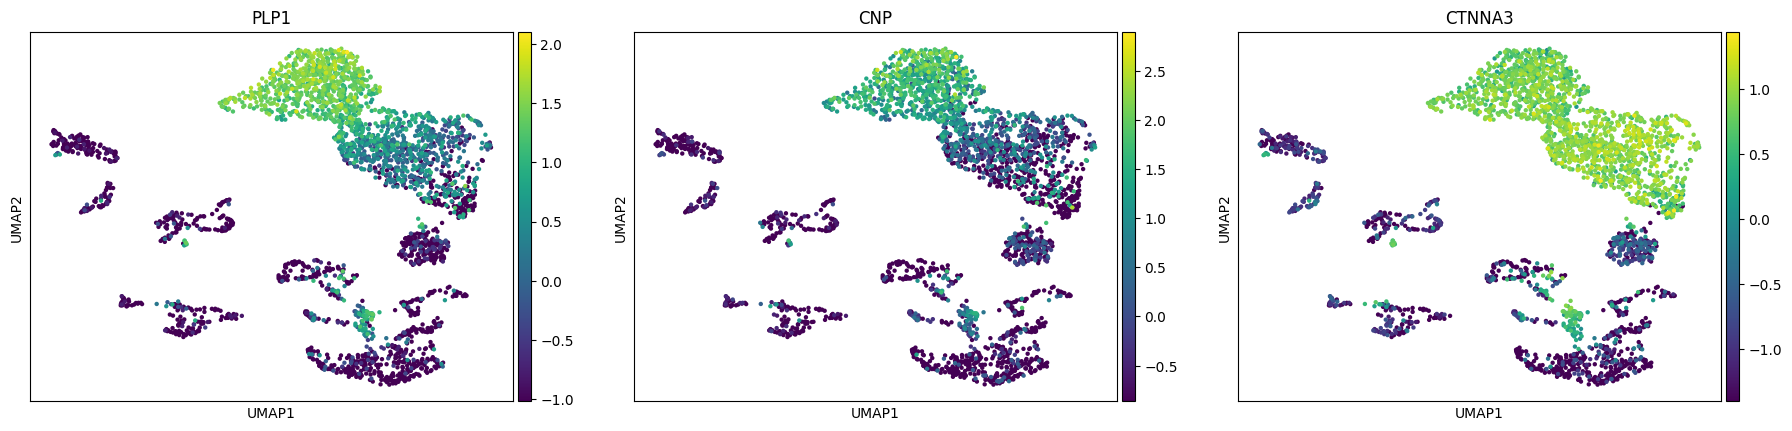

In [27]:
sc.pl.umap(rna, color=["PLP1", "CNP", "CTNNA3"])

Similarly, we can label astrocytes, microglia and oligodendrocyte precursor cells (OPCs):

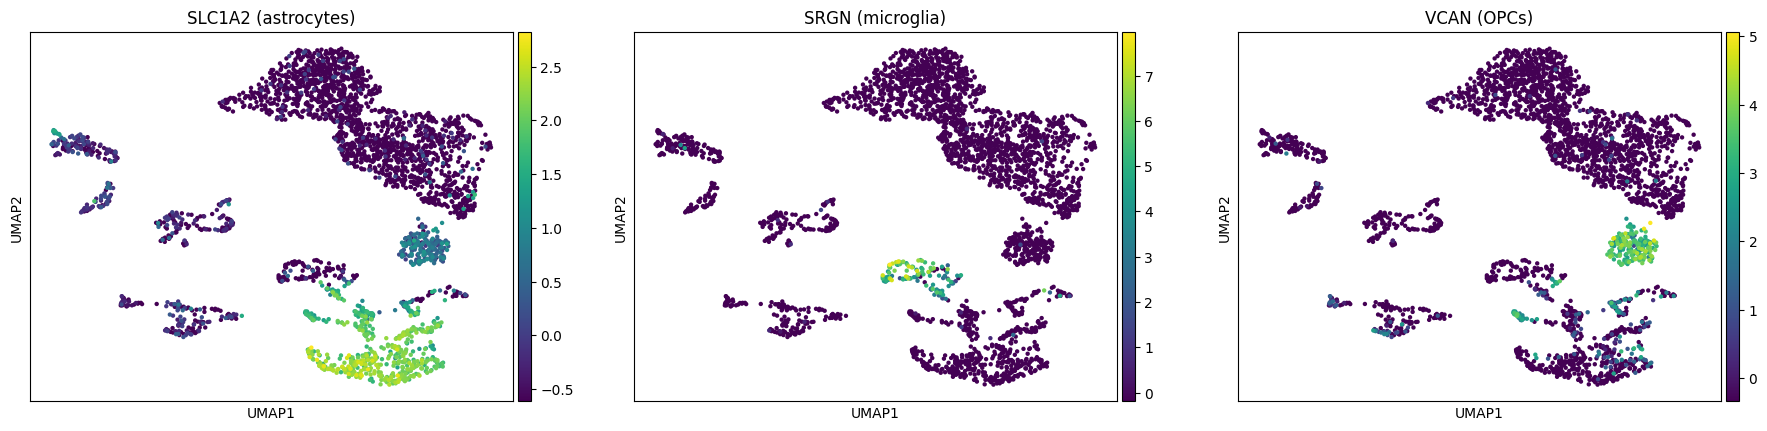

In [28]:
sc.pl.umap(rna, color=["SLC1A2", "SRGN", "VCAN"], 
           title=["SLC1A2 (astrocytes)", "SRGN (microglia)", "VCAN (OPCs)"])

There are a few markers that are used to distinguish between inhibitory and excitatory neurons (see e.g. [Hodge2019](https://www.nature.com/articles/s41586-019-1506-7)):

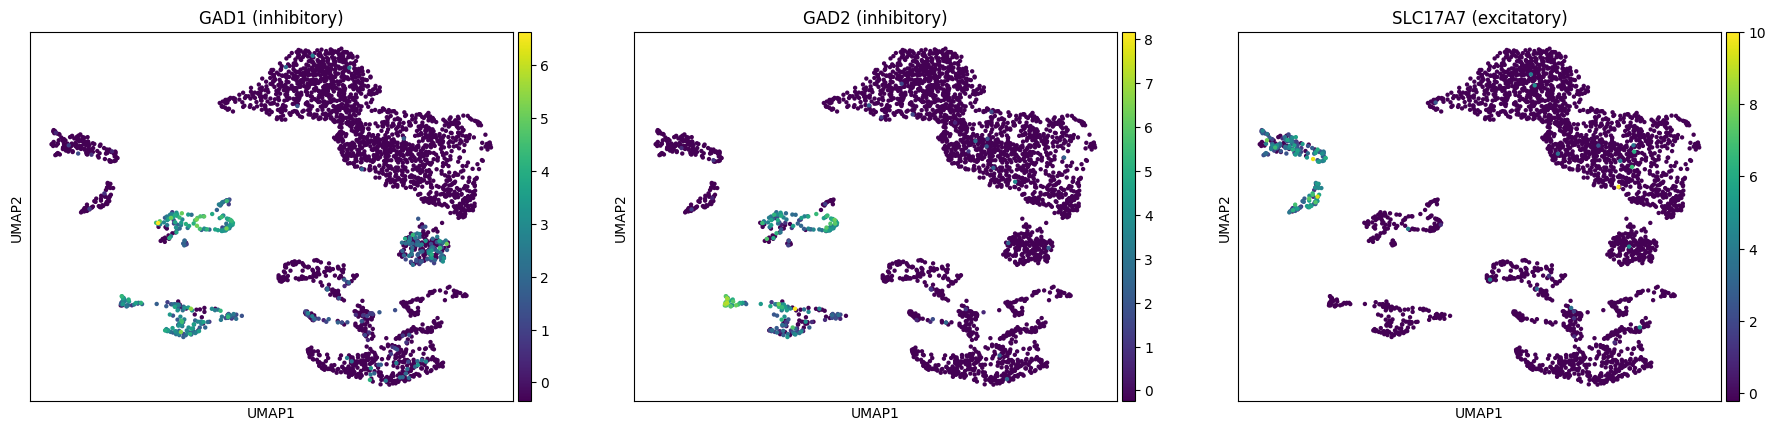

In [29]:
sc.pl.umap(rna, color=["GAD1", "GAD2", "SLC17A7"],
           title=["GAD1 (inhibitory)", "GAD2 (inhibitory)", "SLC17A7 (excitatory)"])

E.g. from [the same paper](https://www.nature.com/articles/s41586-019-1506-7) we can learn that inhibitory neurons form two major branches distinguished by expression of `ADARB2` and `LHX6`:

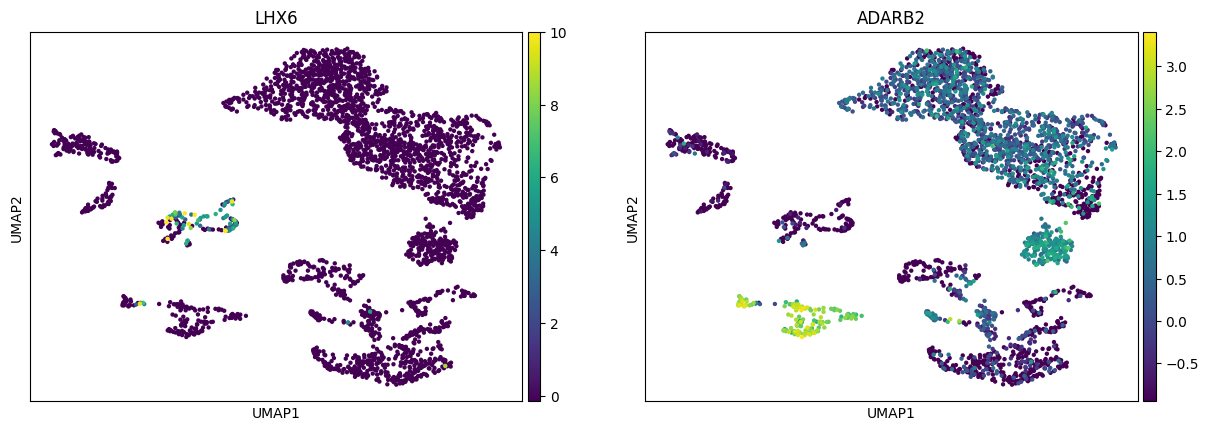

In [30]:
sc.pl.umap(rna, color=["LHX6", "ADARB2"])

Analogously, different excitatory neurons subtypes can be distinguished:

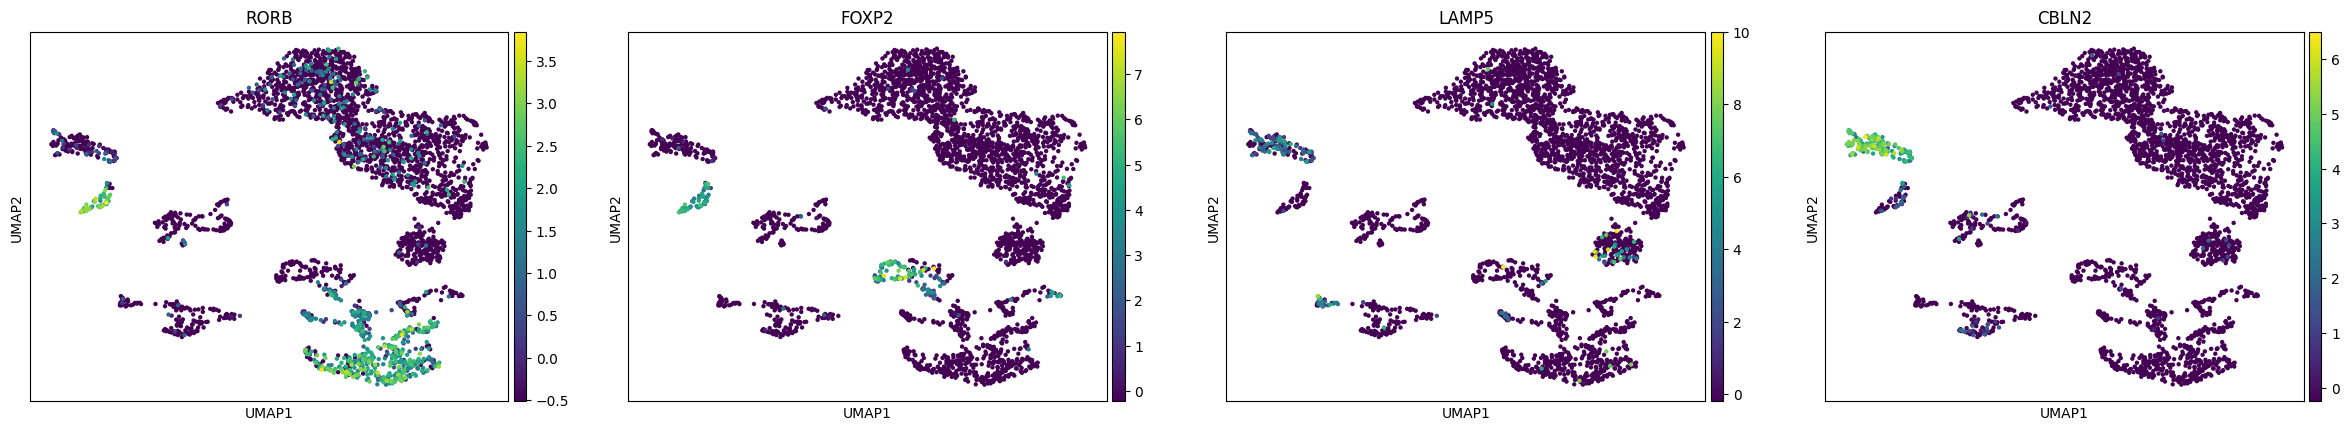

In [31]:
sc.pl.umap(rna, color=["RORB", "FOXP2", "LAMP5", "CBLN2"])

In [32]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "oligodendrocyte",
    "5": "oligodendrocyte",
    "14": "oligodendrocyte",
    "4": "OPC",
    "8": "microglia",
    "2": "astrocyte",
    "10": "astrocyte",
    "11": "astrocyte",
    "12": "astrocyte",
    "6": "excitatory_LAMP5",
    "13": "excitatory_RORB",
    "7": "inhibitory_LHX6",
    "9": "inhibitory_ADARB2",
    "15": "inhibitory_ADARB2",
}

In [33]:
rna.obs['celltype'] = [new_cluster_names[cl] for cl in rna.obs.leiden.astype("str").values]
rna.obs.celltype = rna.obs.celltype.astype("category")

We will also re-order categories for the next plots:

In [34]:
rna.obs.celltype = rna.obs.celltype.cat.set_categories([
    'oligodendrocyte', 'OPC', 'microglia', 'astrocyte',
    'excitatory_LAMP5', 'excitatory_RORB',
    'inhibitory_LHX6', 'inhibitory_ADARB2'
])

In [35]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(to_hex, colors))

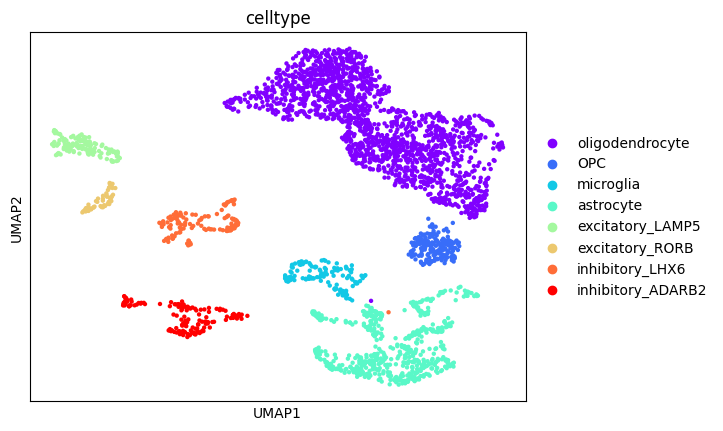

In [36]:
sc.pl.umap(rna, color="celltype")

Finally, we'll visualise some marker genes across cell types.

In [37]:
marker_genes = ["PLP1", "CNP", "CTNNA3",
                "VCAN", "SRGN", "SLC1A2",
                "SLC17A7", "LAMP5", "CBLN2", "RORB", "FOXP2", 
                "GAD1", "GAD2", "LHX6", "ADARB2",]

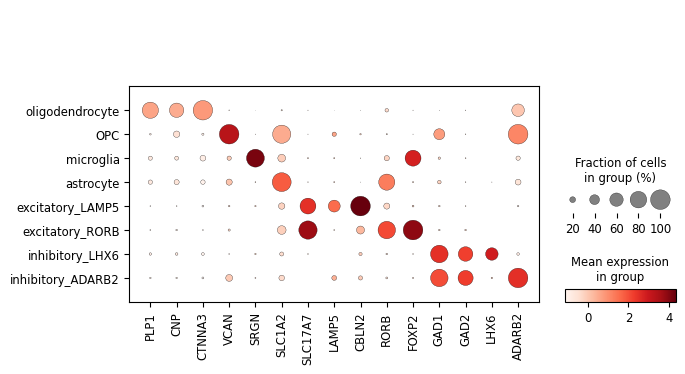

In [38]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

## Preprocessing ATAC

In [39]:
from muon import atac as ac

Here, we'll perform some QC and processing steps including normalisation.

In [40]:
atac = mdata.mod['atac']

### QC

In [41]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

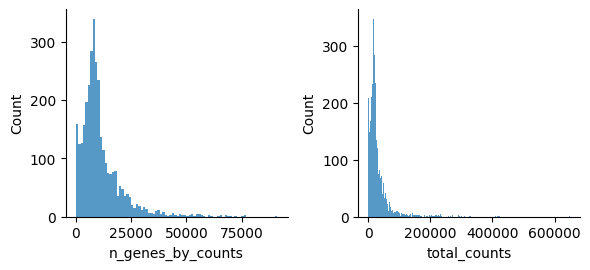

In [42]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Filter peaks which accessibility is not detected:

In [43]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

Filter cells:

In [44]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac.n_obs} cells)")
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac.n_obs} cells")

Before: 3233 cells
(After total_counts: 2977 cells)
After: 2976 cells


Let's see how the data looks after filtering:

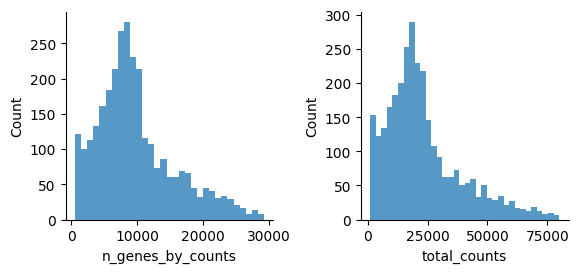

In [45]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

There are a few expectations about how ATAC-seq data looks like as noted [in the hitchhiker’s guide to ATAC-seq data analysis](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#citeas) for instance.

#### Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

To work with the fragments file, `pysam` is required.

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


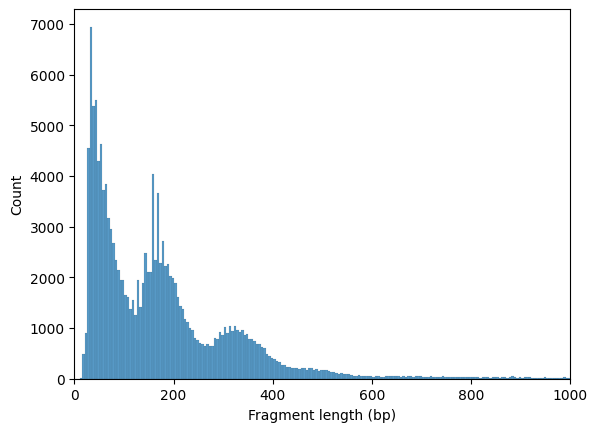

In [46]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called *nucleosome signal*, and it can be estimated using a subset of fragments.

In [47]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:05<00:00, 198104.18it/s]


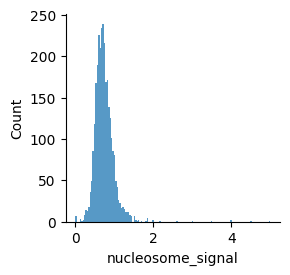

In [48]:
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

#### TSS enrichment

We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the `interval` field of the gene annotation in the `rna` modality:

In [49]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

Chromosome  Start    End          gene_id    gene_name
MIR1302-2HG       chr1  29553  30267  ENSG00000243485  MIR1302-2HG
FAM138A           chr1  36080  36081  ENSG00000237613      FAM138A
OR4F5             chr1  65418  69055  ENSG00000186092        OR4F5

TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `bases` correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [50]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████| 1000/1000 [00:16<00:00, 59.73it/s]


In [51]:
tss

AnnData object with n_obs × n_vars = 2976 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

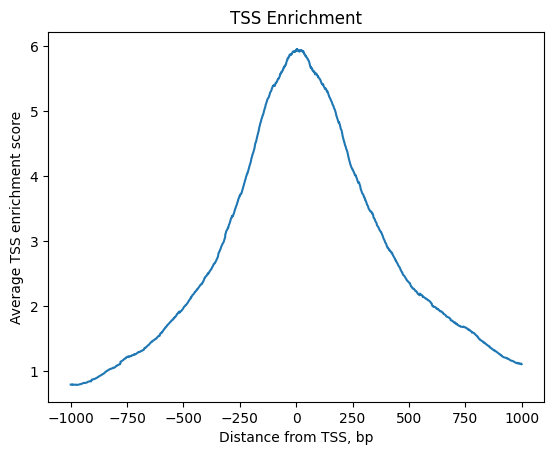

In [52]:
ac.pl.tss_enrichment(tss)

### Normalisation

In [53]:
atac.layers["counts"] = atac.X.copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers["lognorm"] = atac.X.copy()

There can be multiple options for ATAC-seq data normalisation.

Here we will use the same log-normalisation and PCA that we are used to from scRNA-seq analysis, however we note there's also `ac.pp.tfidf()` that can be used on the `atac` with `atac.X` containing counts.

### Define informative features

In [54]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

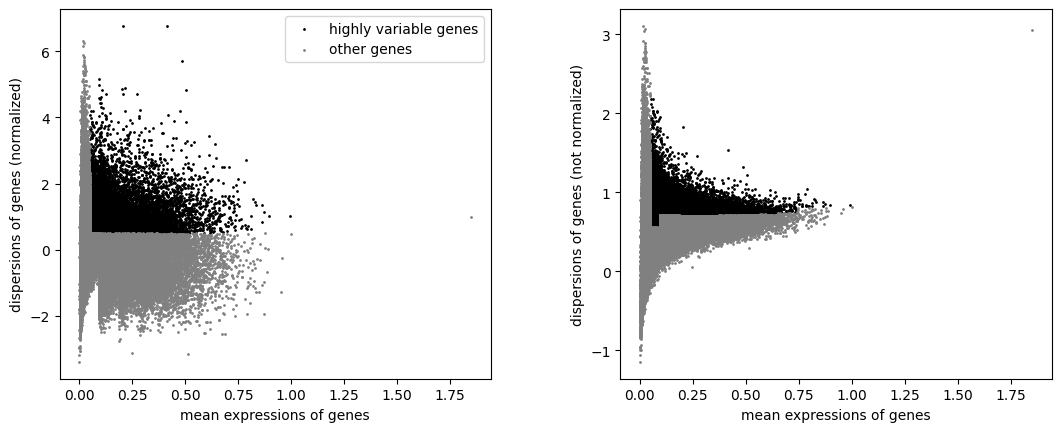

In [55]:
sc.pl.highly_variable_genes(atac)

In [56]:
np.sum(atac.var.highly_variable)

13877

### Scaling and PCA

In [57]:
sc.pp.scale(atac, max_value=10)

In [58]:
sc.tl.pca(atac, svd_solver='arpack')

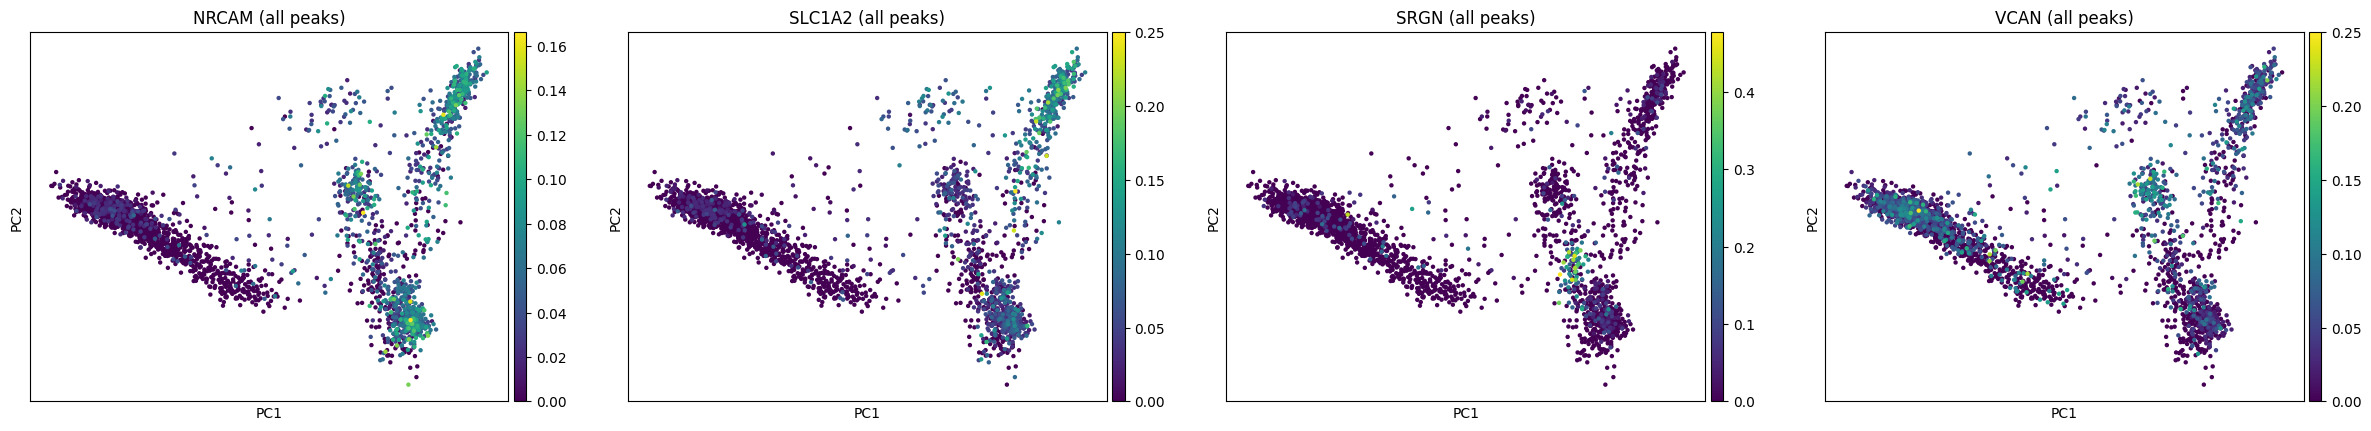

In [59]:
ac.pl.pca(atac, color=['NRCAM', 'SLC1A2', 'SRGN', 'VCAN'], layer='lognorm', func='mean')

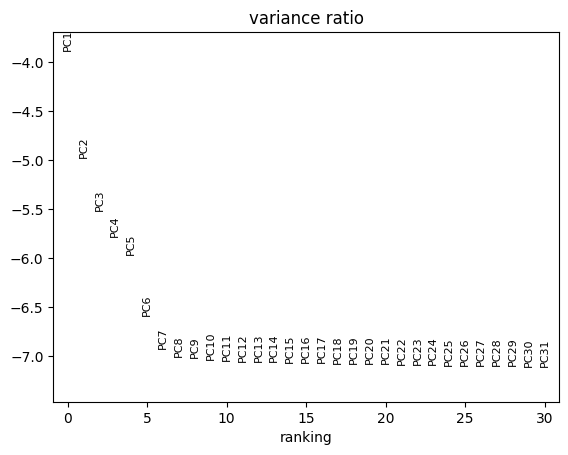

In [60]:
sc.pl.pca_variance_ratio(atac, log=True)

### Finding cell neighbours and clustering cells

In [61]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)

In [62]:
sc.tl.leiden(atac, resolution=.5)

### Non-linear dimensionality reduction

In [63]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


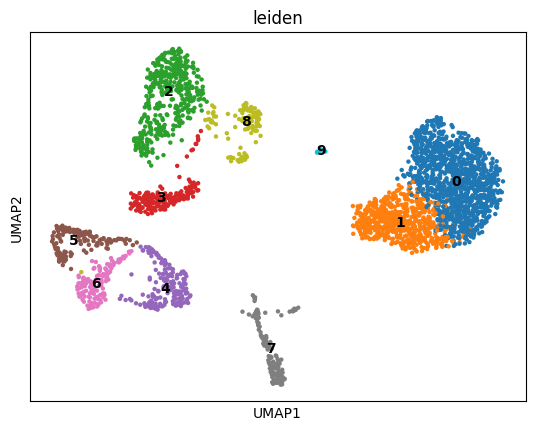

In [64]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

### Marker genes and celltypes

In [65]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/opt/python@3.8/Frameworks/Python.

In [66]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

try:
    pd.set_option("max_columns", 50)
except:
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    pd.set_option("display.max_columns", 50)

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n                  0_g            0_p  \
0   chr19:10517127-10518023                S1PR5  3.282859e-120   
1     chr17:4533823-4534672       MYBBP1A, SPNS2  1.496385e-105   
2  chr9:137025205-137026128      ABCA2, C9orf139  3.410716e-103   
3   chr16:19005407-19006339                 TMC7   4.832642e-96   
4     chr16:1046313-1047208           AC009041.3   1.443936e-92   
5  chr9:137021806-137022721      C9orf139, ABCA2   4.150217e-90   
6    chr1:25563471-25564360  LDLRAP1, AL606491.1   1.641379e-88   
7        chr5:669160-670066     TPPP, AC026740.1   3.579202e-86   
8  chr9:128408873-128409744               CERCAM   4.301388e-84   
9   chr20:48656406-48657246    AL035106.1, PREX1   1.801061e-83   

                        1_n                1_g           1_p  \
0  chr9:137194149-137195061        SSNA1, TPRN  1.687440e-07   
1  chr2:155733016-155733956                     2.192973e-07   
2   chr11:67410019-67410923   CARNS1, TBC1D10C  2.165031e-07   
3   chr22:27641917-27642832         AL121885.3  4.611435e-07   
4  chr3:134366739-134367654             AMOTL2  5.778747e-07   
5    chr1:26555262-26556177            RPS6KA1  6.391270e-07   
6    chr2:16069783-16070654             GACAT3  2.328614e-06   
7  chr9:137025205-137026128    ABCA2, C9orf139  2.419066e-06   
8   chr20:48656406-48657246  AL035106.1, PREX1  2.625672e-06   
9     chr19:6515932-6516671             TUBB4A  3.436492e-06   

                         2_n        2_g           2_p  \
0    chr15:88954455-88955355      MFGE8  1.041462e-51   
1  chr11:116113975-116114894  LINC02703  3.233616e-48   
2      chr17:7667553-7668441       TP53  1.768672e-45   
3     chr2:63050200-63051132       OTX1  6.880293e-44   
4  chr10:117551948-117552792     EMX2OS  4.414343e-43   
5     chr3:47542326-47543264       ELP6  1.358418e-42   
6       chr4:7244199-7245095     SORCS2  2.033508e-42   
7     chr3:93470143-93471053             3.309390e-44   
8     chr1:59986377-59987289     CYP2J2  7.442040e-42   
9    chr11:35462968-35463888      PAMR1  1.023938e-41   

                         3_n                     3_g           3_p  \
0    chr20:64205357-64206289                    MYT1  2.161747e-24   
1   chr1:235649644-235650468                    GNG4  1.018436e-19   
2   chr7:159144522-159145447                   VIPR2  1.325963e-19   
3  chr10:115092748-115093673                  ATRNL1  1.429046e-19   
4    chr22:37412328-37413244                   ELFN2  1.669758e-19   
5   chr1:103108243-103109114                 COL11A1  3.066915e-19   
6    chr14:28766242-28767112                   FOXG1  1.565355e-18   
7   chr3:119329382-119330238  ARHGAP31-AS1, ARHGAP31  2.371422e-18   
8       chr6:3227300-3228175                  TUBB2B  4.510227e-18   
9    chr16:88375908-88376817                  ZNF469  1.888004e-17   

                       4_n                 4_g           4_p  \
0   chr3:93470143-93471053                      7.728457e-64   
1  chr19:17830561-17831448         JAK3, INSL3  1.501875e-26   
2  chr22:20424868-20425672              SCARF2  1.767269e-23   
3     chr3:6860613-6861507                GRM7  1.402679e-23   
4   chr3:11136760-11137765                HRH1  1.013443e-22   
5   chr2:96148230-96149146          AC012307.1  1.741706e-21   
6  chr19:42352133-42353032               MEGF8  8.060144e-21   
7   chr7:45407786-45408730          AC073325.1  1.055004e-19   
8       chr5:912329-913117  TRIP13, AC122719.3  1.287305e-19   
9    chr12:2998746-2999574               TEAD4  1.546582e-19   

                         5_n                   5_g           5_p  \
0   chr2:172102411-172103256         DLX2, DLX2-DT  2.862112e-17   
1    chr19:17830561-17831448           JAK3, INSL3  1.785222e-13   
2    chr11:43580653-43581568  MIR670HG, AC068205.1  2.103368e-13   
3   chr1:159141445-159142305                 CADM3  6.791239e-13   
4    chr20:63501902-63502698            AL121829.1  7.636812e-13   
5    chr20:38723830-38724734               SLC32A1  1.403797e-12   
6

`TMC7`, `CERCAM`, `TUBB4A` (clusters 0 and 1) are oligodendrocyte markers.

Cluster 4 genes (`GRM7`, `MEGF8`) point to excitatory neurons, cluster 5 and 6 genes `DLX1`/`DLX2`, `SLC32A1`, `CADM3` point to inhibitory neurons, cluster 7 genes (`DENND3`) — to microglia.

Cluster 3 genes (`MYT1` — Myelin transcription factor, `GNG4`, etc.) point to OPCs. `OTX1` (cluster 2) is an astrocyte marker, just as `ADGRV1` is in cluster 8.

Adenylate kinase 3 (`AK3` in cluster 9) [is mainly expressed in mitochondria](https://www.proteinatlas.org/ENSG00000147853-AK3) so this is likely a low-quality cell cluster.

Having studied markers of individual clusters, we will filter some cells out before assigning cell types names to clusters.

In [67]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9"]))

In [68]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "OPC",
    "7": "microglia",
    "2": "astrocyte",
    "8": "astrocyte",
    "4": "excitatory",
    "5": "inhibitory1",
    "6": "inhibitory2",
}

In [69]:
atac.obs['celltype'] = [new_cluster_names[cl] for cl in atac.obs.leiden.astype("str").values]
atac.obs.celltype = atac.obs.celltype.astype("category")

We will also re-order categories for the next plots:

In [70]:
atac.obs.celltype = atac.obs.celltype.cat.set_categories([
    'oligodendrocyte', 'OPC', 'microglia', 'astrocyte',
    'excitatory', 'inhibitory1', 'inhibitory2'
])

In [71]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(to_hex, colors))

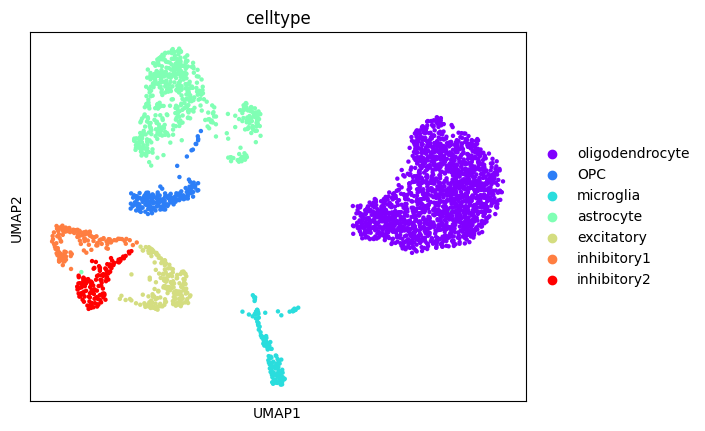

In [72]:
sc.pl.umap(atac, color="celltype")

We can also visualise the same marker genes we plotted for the RNA modality to see if peak accessibility, whether for promoters or for enhancers, resembles the cell type-specific behaviour of these genes.

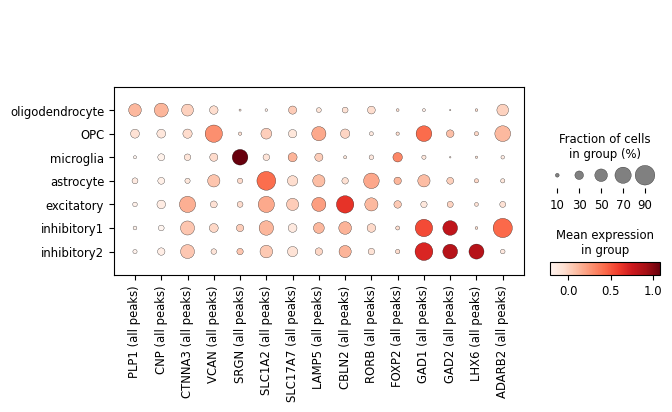

In [73]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

## Multi-omics integration

We'll update the MuData object with the information from the modalities and discard cells that are not in both modalities (cells were filtered independently in two modalities).

In [75]:
mdata.update()

In [76]:
mu.pp.intersect_obs(mdata)

### MOFA

MOFA ([Argelaguet, Arnol, Bredikhin et al., 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1)) is a statistical framework for comprehensive integration of multi-omics data.

In [77]:
mu.tl.mofa(mdata, n_factors=20, outfile="brain3k_mofa_model.hdf5", gpu_mode=True)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=2821 samples and D=5924 features...
Loaded view='atac' group='group1' with N=2821 samples and D=13877 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

In [78]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

In [79]:
mdata.obsm["X_mofa_umap"] = mdata.obsm["X_umap"]

... storing 'rna:leiden' as categorical
... storing 'rna:celltype' as categorical
... storing 'atac:leiden' as categorical
... storing 'atac:celltype' as categorical


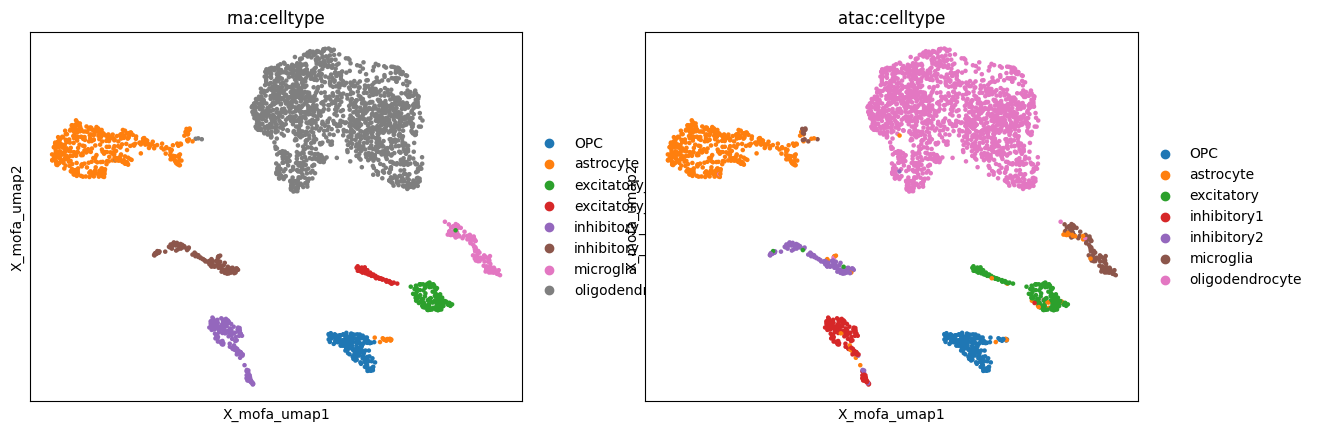

In [80]:
mu.pl.embedding(mdata, basis="X_mofa_umap", color=["rna:celltype", "atac:celltype"])

### WNN

WNN ([Hao, Hao et al., 2021](https://doi.org/10.1016/j.cell.2021.04.048)) is an unsupervised framework for integrative analysis of multiple modalities.

In [81]:
# Since subsetting was performed after calculating nearest neighbours,
# we have to calculate them again for each modality.
sc.pp.neighbors(mdata['rna'])
sc.pp.neighbors(mdata['atac'])

# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')

In [82]:
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)

In [83]:
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

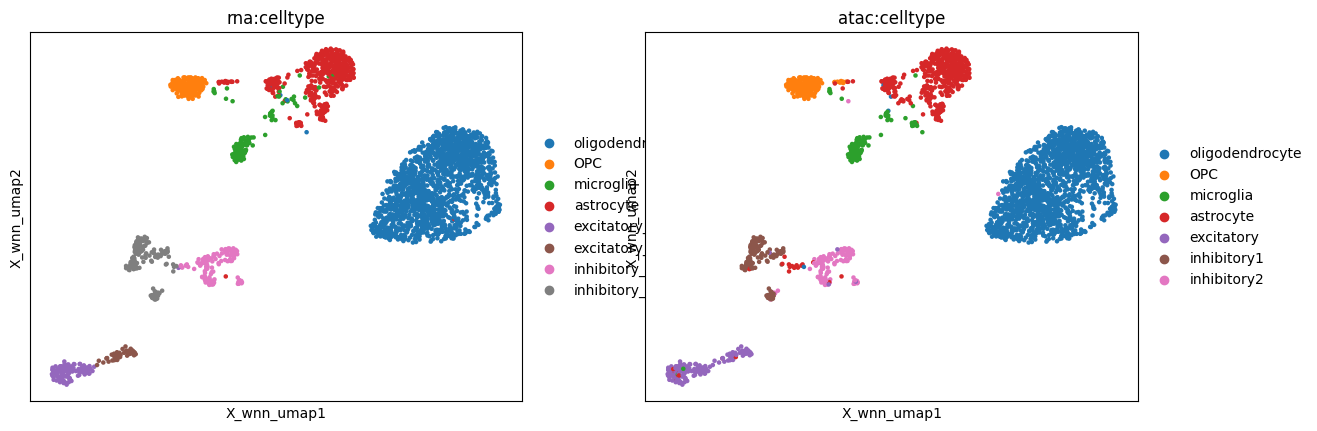

In [84]:
mu.pl.embedding(mdata, basis="X_wnn_umap", color=["rna:celltype", "atac:celltype"])

## Snapshot

We will now save the `mdata` object to an `.h5mu` file.

In [85]:
mdata.write("data/brain3k_processed.h5mu")

... storing 'feature_types' as categorical
... storing 'interval' as categorical


[Next, we'll look into cell type annotation in detail.](2-Celltype-Annotation.ipynb)
